# Understanding Conditional Variance and Conditional Covariance
Reference:
* https://towardsdatascience.com/understanding-conditional-variance-and-conditional-covariance-8b661067fc18

In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import scipy.stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
#Read the automobiles dataset into a Pandas DataFrame
df = pd.read_csv('automobile_uciml_6vars.csv', header=0)
df.rename(columns={"Num_Cyclinders":"Num_Cylinders"}, inplace=True)
#Drop all empty rows
df = df.dropna()
df.head(5)

,City_MPG,Curb_Weight,Vehicle_Volume,Num_Cylinders,Vehicle_Price,Engine_Size
0,21,2548,528019.904,4,13495.0,130
1,21,2548,528019.904,4,16500.0,130
2,19,2823,587592.640,6,16500.0,152
3,24,2337,634816.956,4,13950.0,109
4,18,2824,636734.832,5,17450.0,136


In [3]:
#Group the DataFrame by Num_Cylinders and calculate the mean for each group
df_grouped_means = df.groupby(['Num_Cylinders']).mean()
df_grouped_means

,City_MPG,Curb_Weight,Vehicle_Volume,Vehicle_Price,Engine_Size
Num_Cylinders,,,,,
2,16.750000,2411.250000,550723.680000,13020.000000,72.500000
3,47.000000,1488.000000,452643.156000,5151.000000,61.000000
4,26.980892,2400.923567,605345.272987,10303.197452,113.089172
5,19.900000,3140.600000,731452.330800,22007.600000,154.300000
6,18.291667,3133.958333,657180.528167,23671.833333,185.291667
8,15.000000,3760.000000,776761.442250,38900.000000,270.000000
12,13.000000,3950.000000,646926.156000,36000.000000,326.000000


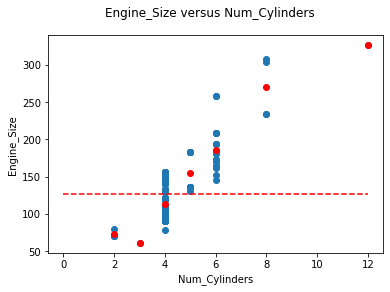

In [4]:
#Plot Engine_Size versus Num_Cylinders
fig = plt.figure()
fig.suptitle('Engine_Size versus Num_Cylinders')
plt.xlabel('Num_Cylinders')
plt.ylabel('Engine_Size')
plt.scatter(df['Num_Cylinders'], df['Engine_Size'])
#Plot a horizontal mean line
plt.plot([0, df['Num_Cylinders'].max()], [df['Engine_Size'].mean(), df['Engine_Size'].mean()], 
         [df['Engine_Size'].mean()], color='red', linestyle='dashed')
#Plot the group-specific means of Engine_Size
for i in df_grouped_means.index:
    mean = df_grouped_means['Engine_Size'].loc[i]
    plt.plot(i, mean, color='red', marker='o')
plt.show()

In [5]:
unconditional_variance_engine_size = df['Engine_Size'].var()
print(f'(Unconditional) sample variance in Engine_Size={str(unconditional_variance_engine_size)}')

(Unconditional) sample variance in Engine_Size=1726.1394527363184


In [8]:
#Construct the regression expression. A regression intercept is included by default
olsr_expr = 'Engine_Size ~ Curb_Weight + Vehicle_Volume + Num_Cylinders'
#Carve out the y and X matrices based on the regression expression
y, X = dmatrices(olsr_expr, df, return_type='dataframe')
#Build the OLS linear regression model
olsr_model = sm.OLS(endog=y, exog=X)
#Train the model
olsr_model_results = olsr_model.fit()
#Make the predictions on the training data set. These are the conditional expectations of y
y_pred=olsr_model_results.predict(X)
y_pred=np.array(y_pred)
#Convert y from a Pandas DataFrame into an array
y=np.array(y['Engine_Size'])
#Calculate the conditional variance in Engine_Size using equation (2)
conditional_variance_engine_size = np.sum(np.square(y-y_pred))/(len(y)-1)
print('Conditional variance in Engine_Size='+str(conditional_variance_engine_size))

Conditional variance in Engine_Size=167.4257832903994


In [9]:
print(f'R-squared of Engine_Size: {1-conditional_variance_engine_size/unconditional_variance_engine_size}')

R-squared of Engine_Size: 0.9030056447496221


In [17]:
olsr_model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Engine_Size   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     611.3
Date:                Wed, 27 Apr 2022   Prob (F-statistic):           1.67e-99
Time:                        13:17:59   Log-Likelihood:                -799.32
No. Observations:                 201   AIC:                             1607.
Df Residuals:                     197   BIC:                             1620.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -49.4314      8.171     -6.050      0.000     -65.545     -33.318
Curb_Weight        0.0530      0.004     14.115      0.000       0.046       0.060
Vehicle_Volume -7.257e-05    2.1e-05     -3.452      0.001      -0.000   -3.11e-05
Num_Cylinders     19.6494      1.131     17.371      0.000      17.419      21.880
==============================================================================
Omnibus:                       29.090   Durbin-Watson:                   1.251
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.658
Skew:                           0.296   Prob(JB):                     1.17e-33
Kurtosis:                       7.214   Cond. No.                     5.56e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.56e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
covariance = df['Curb_Weight'].cov(df['Engine_Size'])
print(f'Covariance between Curb_Weight and Engine_Size={covariance}')

Covariance between Curb_Weight and Engine_Size=18248.283333333326


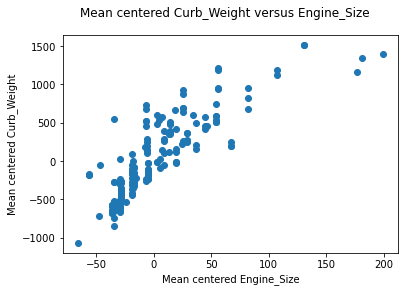

In [21]:
#Plot mean-centered Curb_Weight versus Engine_Size
fig = plt.figure()
fig.suptitle('Mean centered Curb_Weight versus Engine_Size')
plt.xlabel('Mean centered Engine_Size')
plt.ylabel('Mean centered Curb_Weight')
plt.scatter(df['Engine_Size']-df['Engine_Size'].mean(), df['Curb_Weight']-df['Curb_Weight'].mean())
plt.show()

In [22]:
#Carve out the X and W matrices. An intercept is automatically added to W.
X, W = dmatrices('Engine_Size ~ Vehicle_Volume', df, return_type='dataframe')
#Regress X on W
olsr_model_XW = sm.OLS(endog=X, exog=W)
olsr_model_XW_results = olsr_model_XW.fit()
#Get the conditional expectations E(X|W)
X_pred=olsr_model_XW_results.predict(W)
X_pred=np.array(X_pred)
X=np.array(df['Engine_Size'])
#Carve out the Z and W matrices
Z, W = dmatrices('Curb_Weight ~ Vehicle_Volume', df, return_type='dataframe')
#Regress Z on W
olsr_model_ZW = sm.OLS(endog=Z, exog=W)
olsr_model_ZW_results = olsr_model_ZW.fit()
#Get the conditional expectations E(Z|W)
Z_pred=olsr_model_ZW_results.predict(W)
Z_pred=np.array(Z_pred)
Z=np.array(df['Curb_Weight'])
#Construct the delta matrices
Z_delta=Z-Z_pred
X_delta=X-X_pred

#Calculate the conditional covariance
conditional_variance = np.sum(Z_delta*X_delta)/(len(Z)-1)
print(f'Conditional Covariance between Curb_Weight and Engine_Size={conditional_variance}')

Conditional Covariance between Curb_Weight and Engine_Size=7789.498082862664
